# PySpark Classification dengan Random Forest

---

**Nama:** Muhammad Rizky Hajar  
**NIM:** 24.55.2714  
**Prodi:** PJJ Informatika  
**Konsentrasi:** Big Data dan Predictive Analytics (BDPA)  
**Mata Kuliah:** IT Platform and Infrastructure

---

## Tugas 2: PySpark Hadoop Classification

**Konteks Tugas:**
- Menggunakan PySpark dengan Hadoop
- Klasifikasi dengan 4 kelas
- Algoritma klasifikasi selain Logistic Regression (menggunakan **Random Forest**)
- Dataset: Wine Quality (Red Wine) dari UCI ML Repository

---

## Wine Quality Dataset - 4 Class Classification

Notebook ini mendemonstrasikan klasifikasi multiclass menggunakan PySpark MLlib dengan algoritma Random Forest.

### Struktur:
1. Setup & Import
2. Load & Explore Data
3. Preprocessing
4. Model Training
5. Evaluation
6. Feature Importance

## 1. Setup & Import

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import DoubleType, IntegerType

# MLlib imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("WineQualityClassification") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Set log level to reduce noise
spark.sparkContext.setLogLevel("WARN")

print(f"Spark Version: {spark.version}")
print(f"Spark Session: {spark}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/22 18:09:55 WARN Utils: Your hostname, Rizkys-MacBook-Air-M4.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.154 instead (on interface en0)
26/01/22 18:09:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/22 18:09:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.1.1
Spark Session: <pyspark.sql.session.SparkSession object at 0x1228df2f0>


## 2. Load & Explore Data

In [3]:
# Load Wine Quality dataset (semicolon separated)
df = spark.read.csv(
    "../data/winequality-red.csv",
    header=True,
    inferSchema=True,
    sep=";"
)

print(f"Dataset loaded: {df.count()} rows, {len(df.columns)} columns")

Dataset loaded: 1599 rows, 12 columns


In [4]:
# Show schema
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [5]:
# Preview data
df.show(10, truncate=False)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|pH  |sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|7.4          |0.7             |0.0        |1.9           |0.076    |11.0               |34.0                |0.9978 |3.51|0.56     |9.4    |5      |
|7.8          |0.88            |0.0        |2.6           |0.098    |25.0               |67.0                |0.9968 |3.2 |0.68     |9.8    |5      |
|7.8          |0.76            |0.04       |2.3           |0.092    |15.0               |54.0                |0.997  |3.26|0.65     |9.8    |5      |
|11.2         |0.28            |0.56       |1.9           |0.075    |17.0               |60.0       

In [6]:
# Statistical summary
df.describe().toPandas()

26/01/22 18:10:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,count,1599,1599,1599,1599,1599,1599,1599,1599,1599,1599,1599,1599
1,mean,8.319637273295838,0.5278205128205131,0.2709756097560964,2.5388055034396517,0.08746654158849257,15.874921826141339,46.46779237023139,0.9967466791744831,3.311113195747343,0.6581488430268921,10.422983114446502,5.6360225140712945
2,stddev,1.7410963181276948,0.17905970415353525,0.19480113740531824,1.40992805950728,0.047065302010090085,10.46015696980971,32.89532447829907,0.0018873339538427265,0.15438646490354271,0.1695069795901101,1.0656675818473935,0.8075694397347051
3,min,4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3
4,max,15.9,1.58,1.0,15.5,0.611,72.0,289.0,1.00369,4.01,2.0,14.9,8


In [7]:
# Check original quality distribution
print("Original Quality Distribution:")
df.groupBy("quality").count().orderBy("quality").show()

Original Quality Distribution:
+-------+-----+
|quality|count|
+-------+-----+
|      3|   10|
|      4|   53|
|      5|  681|
|      6|  638|
|      7|  199|
|      8|   18|
+-------+-----+



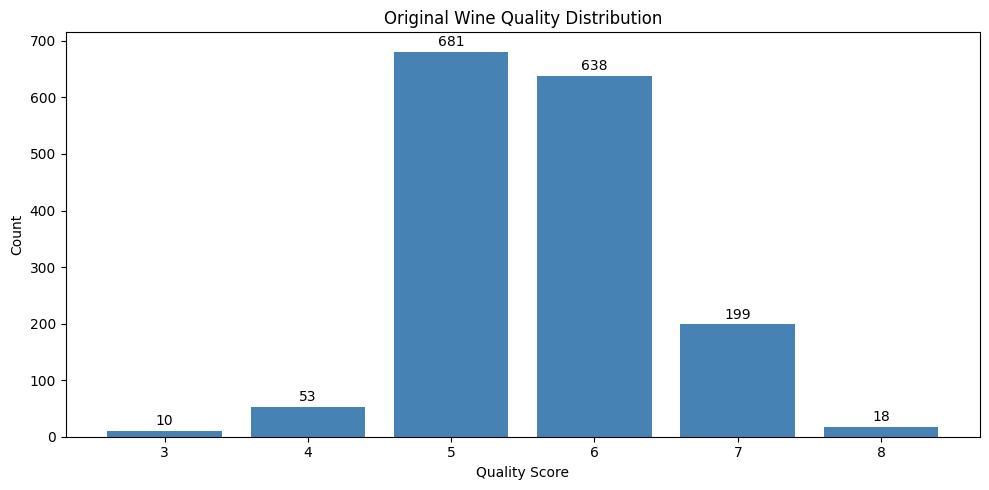

In [8]:
# Visualize original quality distribution
quality_counts = df.groupBy("quality").count().orderBy("quality").toPandas()

plt.figure(figsize=(10, 5))
plt.bar(quality_counts['quality'].astype(str), quality_counts['count'], color='steelblue')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.title('Original Wine Quality Distribution')
for i, v in enumerate(quality_counts['count']):
    plt.text(i, v + 10, str(v), ha='center')
plt.tight_layout()
plt.show()

## 3. Preprocessing

### 3.1 Bucket Quality Score menjadi 4 Kelas

Mapping:
- **0 (Bad)**: quality 3-4
- **1 (Average)**: quality 5
- **2 (Good)**: quality 6
- **3 (Excellent)**: quality 7-8

In [9]:
# Create 4-class label from quality score
df_labeled = df.withColumn(
    "label",
    when(col("quality") <= 4, 0)  # Bad
    .when(col("quality") == 5, 1)  # Average
    .when(col("quality") == 6, 2)  # Good
    .otherwise(3)  # Excellent (7-8)
)

# Verify new class distribution
print("4-Class Distribution:")
print("0: Bad (3-4), 1: Average (5), 2: Good (6), 3: Excellent (7-8)\n")
df_labeled.groupBy("label").count().orderBy("label").show()

4-Class Distribution:
0: Bad (3-4), 1: Average (5), 2: Good (6), 3: Excellent (7-8)

+-----+-----+
|label|count|
+-----+-----+
|    0|   63|
|    1|  681|
|    2|  638|
|    3|  217|
+-----+-----+



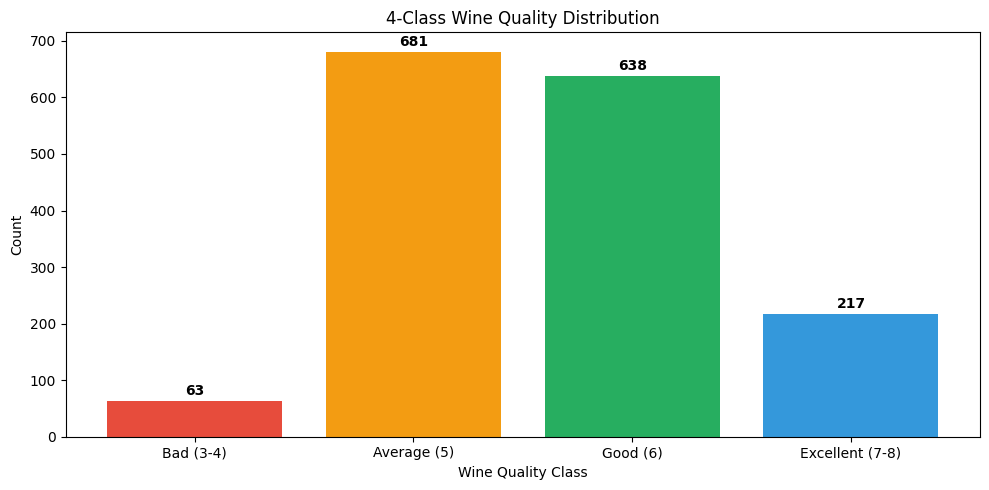

In [10]:
# Visualize 4-class distribution
class_counts = df_labeled.groupBy("label").count().orderBy("label").toPandas()
class_names = ['Bad (3-4)', 'Average (5)', 'Good (6)', 'Excellent (7-8)']

plt.figure(figsize=(10, 5))
colors = ['#e74c3c', '#f39c12', '#27ae60', '#3498db']
plt.bar(class_names, class_counts['count'], color=colors)
plt.xlabel('Wine Quality Class')
plt.ylabel('Count')
plt.title('4-Class Wine Quality Distribution')
for i, v in enumerate(class_counts['count']):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.2 Feature Engineering

In [11]:
# Define feature columns (all columns except quality and label)
feature_columns = [col for col in df.columns if col != 'quality']
print(f"Feature columns ({len(feature_columns)}):")
print(feature_columns)

Feature columns (11):
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [12]:
# Check for null values
print("Null values per column:")
from pyspark.sql.functions import sum as spark_sum, isnan

null_counts = df_labeled.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c) for c in feature_columns]
).toPandas()

print(null_counts.T)

Null values per column:
                      0
fixed acidity         0
volatile acidity      0
citric acid           0
residual sugar        0
chlorides             0
free sulfur dioxide   0
total sulfur dioxide  0
density               0
pH                    0
sulphates             0
alcohol               0


In [13]:
# Create VectorAssembler for features
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="skip"
)

# Transform data
df_assembled = assembler.transform(df_labeled)
df_assembled.select("features", "label").show(5, truncate=False)

+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |1    |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |1    |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |1    |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|2    |
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |1    |
+--------------------------------------------------------+-----+
only showing top 5 rows


### 3.3 Train/Test Split

In [14]:
# Split data: 80% train, 20% test
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count()} samples")
print(f"Test set: {test_data.count()} samples")

Training set: 1324 samples
Test set: 275 samples


In [15]:
# Check class distribution in train/test sets
print("Training set class distribution:")
train_data.groupBy("label").count().orderBy("label").show()

print("Test set class distribution:")
test_data.groupBy("label").count().orderBy("label").show()

Training set class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|   55|
|    1|  559|
|    2|  532|
|    3|  178|
+-----+-----+

Test set class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|    8|
|    1|  122|
|    2|  106|
|    3|   39|
+-----+-----+



## 4. Model Training - Random Forest

In [16]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,           # Number of trees in the forest
    maxDepth=10,            # Maximum depth of each tree
    minInstancesPerNode=5,  # Minimum samples per leaf
    seed=42
)

print("Random Forest Classifier initialized")
print(f"Parameters:")
print(f"  - numTrees: {rf.getNumTrees()}")
print(f"  - maxDepth: {rf.getMaxDepth()}")
print(f"  - minInstancesPerNode: {rf.getMinInstancesPerNode()}")

Random Forest Classifier initialized
Parameters:
  - numTrees: 100
  - maxDepth: 10
  - minInstancesPerNode: 5


In [17]:
# Train the model
print("Training Random Forest model...")
rf_model = rf.fit(train_data)
print("Model training completed!")

Training Random Forest model...


26/01/22 18:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1570.5 KiB
26/01/22 18:10:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
26/01/22 18:10:47 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
26/01/22 18:10:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


Model training completed!


In [18]:
# Make predictions on test set
predictions = rf_model.transform(test_data)

# Show sample predictions
predictions.select("features", "label", "prediction", "probability").show(10, truncate=False)

+----------------------------------------------------------------------+-----+----------+---------------------------------------------------------------------------------+
|features                                                              |label|prediction|probability                                                                      |
+----------------------------------------------------------------------+-----+----------+---------------------------------------------------------------------------------+
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]             |3    |3.0       |[0.0047559088544938035,0.05293779596442267,0.370907717079159,0.5713985781019245] |
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]             |2    |2.0       |[0.028304929880715445,0.13531531812365954,0.7441409574352581,0.09223879456036693]|
|[5.0,1.04,0.24,1.6,0.05,32.0,96.0,0.9934,3.74,0.62,11.5]              |1    |2.0       |[0.08519678517225249,0.33649681950476146,0.39698672

26/01/22 18:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1900.5 KiB


## 5. Model Evaluation

In [19]:
# Create evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedPrecision"
)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedRecall"
)

# Calculate metrics
accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print("="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1 Score:           {f1_score:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print("="*50)

26/01/22 18:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1910.0 KiB
26/01/22 18:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1910.0 KiB


MODEL EVALUATION RESULTS
Accuracy:           0.6909 (69.09%)
F1 Score:           0.6796
Weighted Precision: 0.6795
Weighted Recall:    0.6909


26/01/22 18:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1910.0 KiB
26/01/22 18:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1910.0 KiB


In [20]:
# Create Confusion Matrix
confusion_df = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").toPandas()

# Pivot to matrix form
confusion_matrix = confusion_df.pivot(index='label', columns='prediction', values='count').fillna(0).astype(int)

print("Confusion Matrix:")
print(confusion_matrix)

26/01/22 18:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1903.8 KiB
26/01/22 18:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1885.9 KiB
26/01/22 18:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1885.9 KiB
26/01/22 18:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1885.8 KiB


Confusion Matrix:
prediction  1.0  2.0  3.0
label                    
0             6    2    0
1            92   29    1
2            23   78    5
3             2   17   20


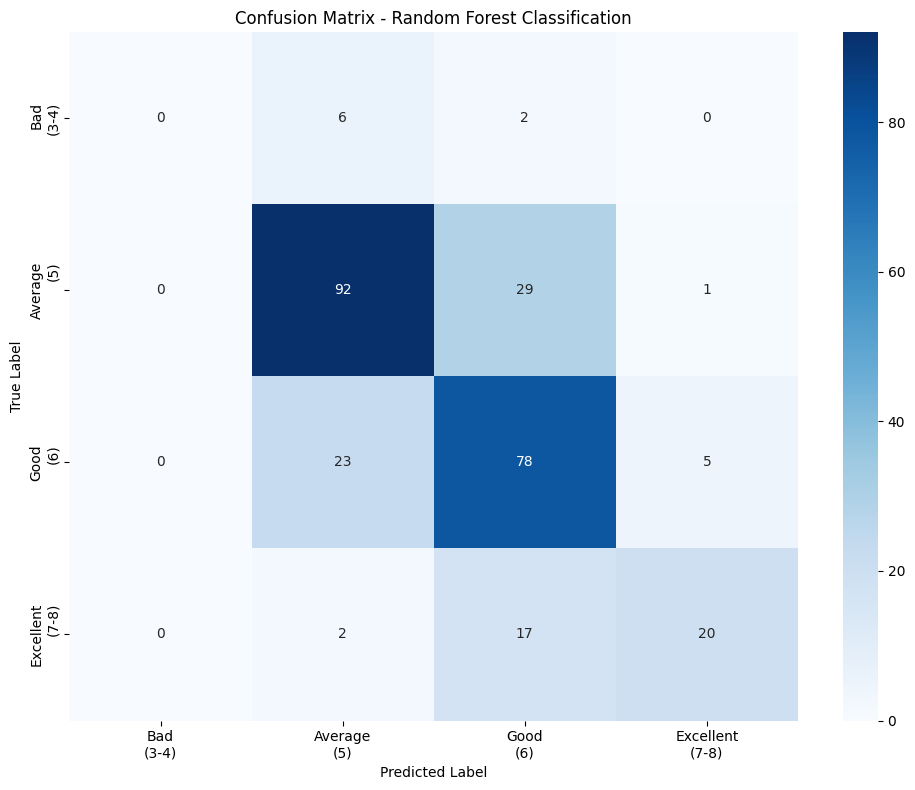

In [21]:
# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
class_labels = ['Bad\n(3-4)', 'Average\n(5)', 'Good\n(6)', 'Excellent\n(7-8)']

# Ensure all classes are represented
cm_full = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        if i in confusion_matrix.index and j in confusion_matrix.columns:
            cm_full[i, j] = confusion_matrix.loc[i, j]

sns.heatmap(
    cm_full.astype(int), 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classification')
plt.tight_layout()
plt.show()

In [22]:
# Per-class metrics
print("\nPer-Class Performance:")
print("-"*50)

for i, class_name in enumerate(class_labels):
    class_name_clean = class_name.replace('\n', ' ')
    
    # Calculate per-class metrics
    tp = cm_full[i, i]
    fp = cm_full[:, i].sum() - tp
    fn = cm_full[i, :].sum() - tp
    
    class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
    
    print(f"Class {i} ({class_name_clean}):")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall:    {class_recall:.4f}")
    print(f"  F1-Score:  {class_f1:.4f}")
    print()


Per-Class Performance:
--------------------------------------------------
Class 0 (Bad (3-4)):
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Class 1 (Average (5)):
  Precision: 0.7480
  Recall:    0.7541
  F1-Score:  0.7510

Class 2 (Good (6)):
  Precision: 0.6190
  Recall:    0.7358
  F1-Score:  0.6724

Class 3 (Excellent (7-8)):
  Precision: 0.7692
  Recall:    0.5128
  F1-Score:  0.6154



## 6. Feature Importance

In [23]:
# Extract feature importance
feature_importance = rf_model.featureImportances.toArray()

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df.to_string(index=False))

Feature Importance Ranking:
             feature  importance
             alcohol    0.220451
           sulphates    0.133514
total sulfur dioxide    0.102282
    volatile acidity    0.100211
           chlorides    0.073593
             density    0.069050
       fixed acidity    0.065910
                  pH    0.060661
         citric acid    0.060479
 free sulfur dioxide    0.060315
      residual sugar    0.053534


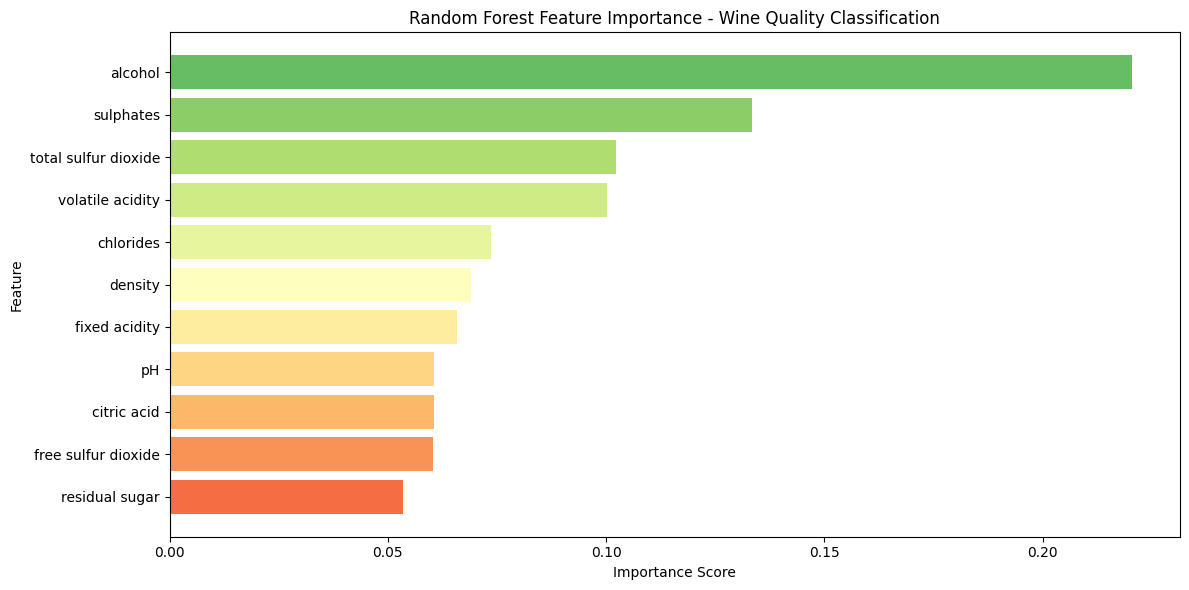

In [24]:
# Visualize Feature Importance
plt.figure(figsize=(12, 6))

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance_df)))
plt.barh(importance_df['feature'], importance_df['importance'], color=colors[::-1])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance - Wine Quality Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Summary & Conclusions

In [25]:
print("="*60)
print("SUMMARY - PYSPARK RANDOM FOREST CLASSIFICATION")
print("="*60)
print(f"\nDataset: Wine Quality (Red Wine)")
print(f"Total Samples: {df.count()}")
print(f"Features: {len(feature_columns)}")
print(f"Classes: 4 (Bad, Average, Good, Excellent)")
print(f"\nTrain/Test Split: 80/20")
print(f"Training Samples: {train_data.count()}")
print(f"Test Samples: {test_data.count()}")
print(f"\nModel: Random Forest Classifier")
print(f"  - Number of Trees: 100")
print(f"  - Max Depth: 10")
print(f"\nPerformance Metrics:")
print(f"  - Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - F1 Score: {f1_score:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"\nTop 3 Important Features:")
for idx, row in importance_df.head(3).iterrows():
    print(f"  - {row['feature']}: {row['importance']:.4f}")
print("="*60)

SUMMARY - PYSPARK RANDOM FOREST CLASSIFICATION

Dataset: Wine Quality (Red Wine)
Total Samples: 1599
Features: 11
Classes: 4 (Bad, Average, Good, Excellent)

Train/Test Split: 80/20
Training Samples: 1324
Test Samples: 275

Model: Random Forest Classifier
  - Number of Trees: 100
  - Max Depth: 10

Performance Metrics:
  - Accuracy: 0.6909 (69.09%)
  - F1 Score: 0.6796
  - Precision: 0.6795
  - Recall: 0.6909

Top 3 Important Features:
  - alcohol: 0.2205
  - sulphates: 0.1335
  - total sulfur dioxide: 0.1023


In [26]:
# Stop Spark Session
spark.stop()
print("Spark session stopped.")

Spark session stopped.
